# 載入模塊

In [264]:
import os
import cv2
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [265]:

def ROC_and_AUC(label, score, name):
    fpr, tpr , _ = roc_curve(label, score)
    roc_auc = auc(fpr, tpr)
    name = name + '_auc = ' + str(roc_auc.round(3))
    lw = 2
    plt.plot(fpr, tpr, lw = lw, label = name)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")

# 整理所有檔名與標記

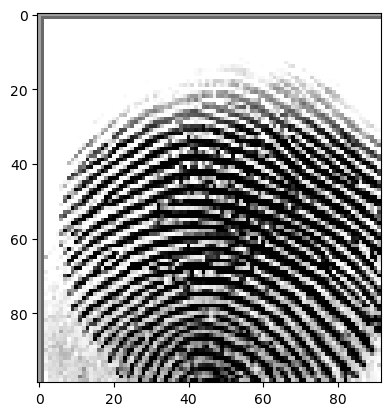

In [266]:
data = pd.read_csv('all_data_info.csv', header=None)
x = data.iloc[:, 0]
y = data.iloc[:, 2]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=1)
imgs = []
for i in x_train:
    img = cv2.imread('imgs/{}'.format(i)) 
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    new = img[0:99, 0:92]
    imgs.append(new)
    plt.imshow(new, cmap='gray')

# 定義Gabor濾波器

In [267]:
# x_train = x
# y_train = y

In [268]:
def Gabor_filter(k_size = 111, sigma = 10, gamma = 1.2, Lambda = 10, psi = 0, angle = 0):
    mid = k_size // 2 # Kernel 中心點
    gabor = np.zeros((k_size, k_size), dtype = np.float32) #建立空的kernel
    
    for y in range(k_size):
        for x in range(k_size):
            px = x - mid
            py = y - mid
            
            theta = angle * np.pi / 180.
            
            x_1 = np.cos(theta) * px + np.sin(theta) * py
            y_1 = -np.sin(theta) * px + np.cos(theta) * py
            
            term_1 = np.exp(-(x_1**2 + gamma**2 * y_1**2) / (2 * sigma**2))
            term_2 = np.cos(2 * np.pi*x_1/Lambda + psi)
            gabor[y, x] = term_1 * term_2
    
    gabor = gabor / np.sum(np.abs(gabor))
    return gabor

# 設定 Gabor 濾波器

In [269]:
all_filter = []

angles = np.arange(0, 180, 30)
Lambdas = [3, 5, 7]
sigma = [3, 7 , 10]
gamma = [0.1, 1]
for la in Lambdas:
    for ang in angles:
        for sig in sigma :
            for gam in gamma:
                all_filter.append(Gabor_filter(k_size = 11,  sigma =sig, gamma = gam , Lambda = la , angle = ang))

size = len(angles)* len(Lambdas)* len(sigma)*len(gamma)

In [270]:
all_feature = np.zeros((x_train.shape[0], size))

for i in range(x_train.shape[0]):
    img = cv2.imread('imgs/{}'.format(x_train.iloc[i]))
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)

    img = (img - np.mean(img)) / np.std(img)
    
    for j in range(size):
        feature_map = signal.convolve2d(img, all_filter[j], mode='same')
        all_feature[i, j] = np.mean(feature_map)
            
feature_mean = np.mean(all_feature, axis=0)
feature_std = np.std(all_feature, axis=0)
norm_feature = (all_feature - feature_mean) / feature_std

test_feature = np.zeros((x_test.shape[0], size))

for i in range(x_test.shape[0]):

    img = cv2.imread('imgs/{}'.format(x_test.iloc[i])) 
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    img = (img - np.mean(img)) / np.std(img)
    
    for j in range(size):
        feature_map = signal.convolve2d(img, all_filter[j], mode='same')
        test_feature[i, j] = np.mean(feature_map)
            
norm_test_feature = (test_feature - feature_mean) / feature_std

In [271]:
from scipy.stats import mannwhitneyu

c_p_value = []

for i in range(norm_feature.shape[1]):
    value1=[]
    value0=[]
    for j in range(norm_feature.shape[0]):
        y_label = y_train.iloc[j]
        if y_label == y_train.iloc[0]:
            value0.append(all_feature[j, i])
        else:
            value1.append(all_feature[j, i])
    result = mannwhitneyu(value0, value1, alternative='two-sided') 
    c_p_value.append(result[1])
    label = []
for i in range(len(c_p_value)):
    if c_p_value[i] < 0.05:
        label.append(i)
print(len(label))



106


In [272]:
new_norm_feature = norm_feature[:, label]
new_norm_test_feature = norm_test_feature[:, label]
X_train = new_norm_feature
X_test = new_norm_test_feature

def onehot(y):
    new_y = []
    for i in range(len(y)):
        if y.iloc[i] == y_train.iloc[0]:
            new_y.append(0)
        else:
            new_y.append(1)
    return new_y
new_y_train = onehot(y_train)
new_y_test = onehot(y_test)

In [273]:
from sklearn.model_selection import GridSearchCV
param_grid = { 'n_neighbors':np.arange(3, 40, 2), 
              'p' : [1, 2]
              }

optimal_params = GridSearchCV(
    KNeighborsClassifier(metric='minkowski'),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
  )

optimal_params.fit(new_norm_feature, y_train)
n_nei = optimal_params.best_params_['n_neighbors']
P = optimal_params.best_params_['p']


Fitting 5 folds for each of 38 candidates, totalling 190 fits


In [274]:
param_grid = { 'max_depth' :np.arange(3, 10, 1),
              'splitter' : ['best', 'random'],
              'min_samples_leaf' : np.arange(5, 10, 2),
              'criterion':['entropy', 'gini']
              }

optimal_params = GridSearchCV(
    DecisionTreeClassifier(random_state=0),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
  )

optimal_params.fit(new_norm_feature, y_train)
Max_depth = optimal_params.best_params_['max_depth']
Splitter = optimal_params.best_params_['splitter']
Min_sample = optimal_params.best_params_['min_samples_leaf']
Criteration = optimal_params.best_params_['criterion']

Fitting 5 folds for each of 84 candidates, totalling 420 fits


In [275]:
from sklearn.model_selection import GridSearchCV
param_grid = { 'C':[0.1, 1, 5, 10],
              'kernel':['linear', 'rbf']
              
              }

optimal_params = GridSearchCV(
    SVC(gamma='auto' , max_iter=-1),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
  )

optimal_params.fit(new_norm_feature, y_train)
SVC_C = optimal_params.best_params_['C']
Kernal = optimal_params.best_params_['kernel']


Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [276]:
param_grid = { 'C' : [1, 0.1, 0.01, 0.001], 
              'penalty': ['l1', 'l2'], 
              'solver' : ['saga', 'liblinear']
              }

optimal_params = GridSearchCV(
    LogisticRegression(random_state=1, max_iter=10000),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = -1,
  )

optimal_params.fit(new_norm_feature, y_train)
c = optimal_params.best_params_['C']
Penalty = optimal_params.best_params_['penalty']
Solver = optimal_params.best_params_['solver']


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [277]:

class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):

    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):

        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):


        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):

        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):

        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

In [278]:
acc = []

clf1 = LogisticRegression(max_iter=10000, C= c, penalty= Penalty, solver= Solver, random_state=1)

clf2 = DecisionTreeClassifier(criterion= Criteration , max_depth= Max_depth, min_samples_leaf= Min_sample, splitter= Splitter, random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=n_nei,p=P,metric='minkowski')

clf4 = SVC(probability=True, kernel=Kernal, C=SVC_C)

clf5 = LDA(solver='eigen', shrinkage = 'auto')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
pipe4 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf4]])
pipe5 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf5]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN', 'SVC', 'LDR']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3, pipe4, pipe5], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=new_y_train ,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')
    acc.append(scores.mean())

    
pd_acc = pd.DataFrame(acc)
label = pd.DataFrame({'label': 'pipe1 clf2 pipe3 pipe4 pipe5'.split()})
pd_acc.insert(label.shape[1], 'label',  label)
sortpd = pd_acc.sort_values(0)

print('top3 model\n', sortpd.iloc[2:5, 1])



10-fold cross validation:

ROC AUC: 0.68 (+/- 0.06) [Logistic regression]
ROC AUC: 0.67 (+/- 0.07) [Decision tree]
ROC AUC: 0.69 (+/- 0.05) [KNN]
ROC AUC: 0.69 (+/- 0.06) [SVC]
ROC AUC: 0.69 (+/- 0.05) [LDR]
top3 model
 4    pipe5
2    pipe3
3    pipe4
Name: label, dtype: object


ROC AUC: 0.68 (+/- 0.06) [Logistic regression]
ROC AUC: 0.67 (+/- 0.07) [Decision tree]
ROC AUC: 0.69 (+/- 0.05) [KNN]
ROC AUC: 0.69 (+/- 0.06) [SVC]
ROC AUC: 0.69 (+/- 0.05) [LDR]
ROC AUC: 0.71 (+/- 0.05) [Majority voting]


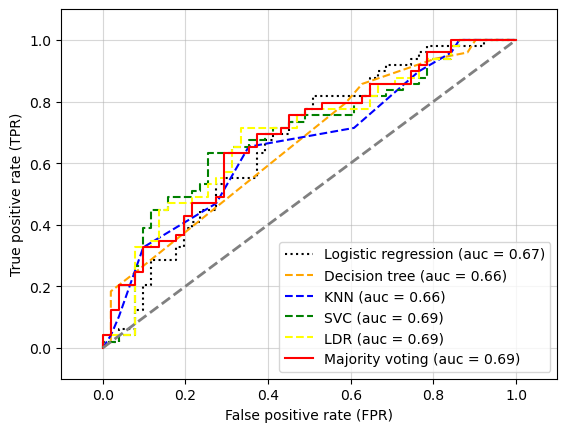

In [279]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, pipe4, pipe5, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, pipe4, pipe5, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=new_y_train ,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


colors = ['black', 'orange', 'blue', 'green', 'yellow', 'red']
linestyles = [':', '--', '--', '--', '--', 'solid']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     new_y_train ).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=new_y_test ,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('figures/07_04', dpi=300)
plt.show()


In [280]:
testing = pd.read_csv('FingerPrint_test_20230104/all_test_info.csv', header=None)
imgs = []
test_name = testing.iloc[:, 0]

In [281]:
test_feature = np.zeros((x_test.shape[0], size))

for i in range(x_test.shape[0]):

    img = cv2.imread('imgs/{}'.format(x_test.iloc[i])) 
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    img = (img - np.mean(img)) / np.std(img)
    
    for j in range(size):
        feature_map = signal.convolve2d(img, all_filter[j], mode='same')
        test_feature[i, j] = np.mean(feature_map)
            
norm_test_feature = (test_feature - feature_mean) / feature_std

In [282]:
test_all_feature = np.zeros((test_name.shape[0], size))

for i in range(test_name.shape[0]):
    img = cv2.imread('FingerPrint_test_20230104/imgs/{}'.format(test_name.iloc[i])) 
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
    img = (img - np.mean(img)) / np.std(img)
    
    for j in range(size):
        feature_map = signal.convolve2d(img, all_filter[j], mode='same')
        test_all_feature[i, j] = np.mean(feature_map)
            

test_norm_feature = (test_all_feature - feature_mean) / feature_std


In [283]:
label = []
for i in range(len(c_p_value)):
    if c_p_value[i] < 0.05:
        label.append(i)
new_test_norm_featuer = test_norm_feature[:, label]

In [284]:
ans = mv_clf.predict(new_test_norm_featuer)

In [285]:
y_train.iloc[0]

'Right'

In [286]:
Ans = []
for i in ans:
    if i == 0:
        Ans.append('M')
    else:
        Ans.append('F')

# 輸出CSV檔

In [287]:
#import csv
# test_info_list = []
# for i in range(100):
#     file_name = 'T' + str(i+1).zfill(3) + '.BMP'
#     test_info_list.append([file_name, Ans[i]])

# with open('final_ans_fingerprintGender.csv', 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(test_info_list)